# Problem 8.1

Attribution: Elena and Michelle with some feedback from Shashank.

First we load the modules we will need.

In [3]:
import warnings
import os
import time
import itertools

# Our numerical workhorse
import numpy as np
import scipy
import pandas as pd
import bebi103

# Image processing tools
import skimage
import skimage.io
import skimage.filters
import skimage.morphology
import skimage.feature
import skimage.segmentation
import skimage.measure

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw
import corner

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Suppress future warnings
warnings.filterwarnings('ignore')

# Part A

First, let's load the images, convert them to float images with maximally stretched pixel values, and display them. 

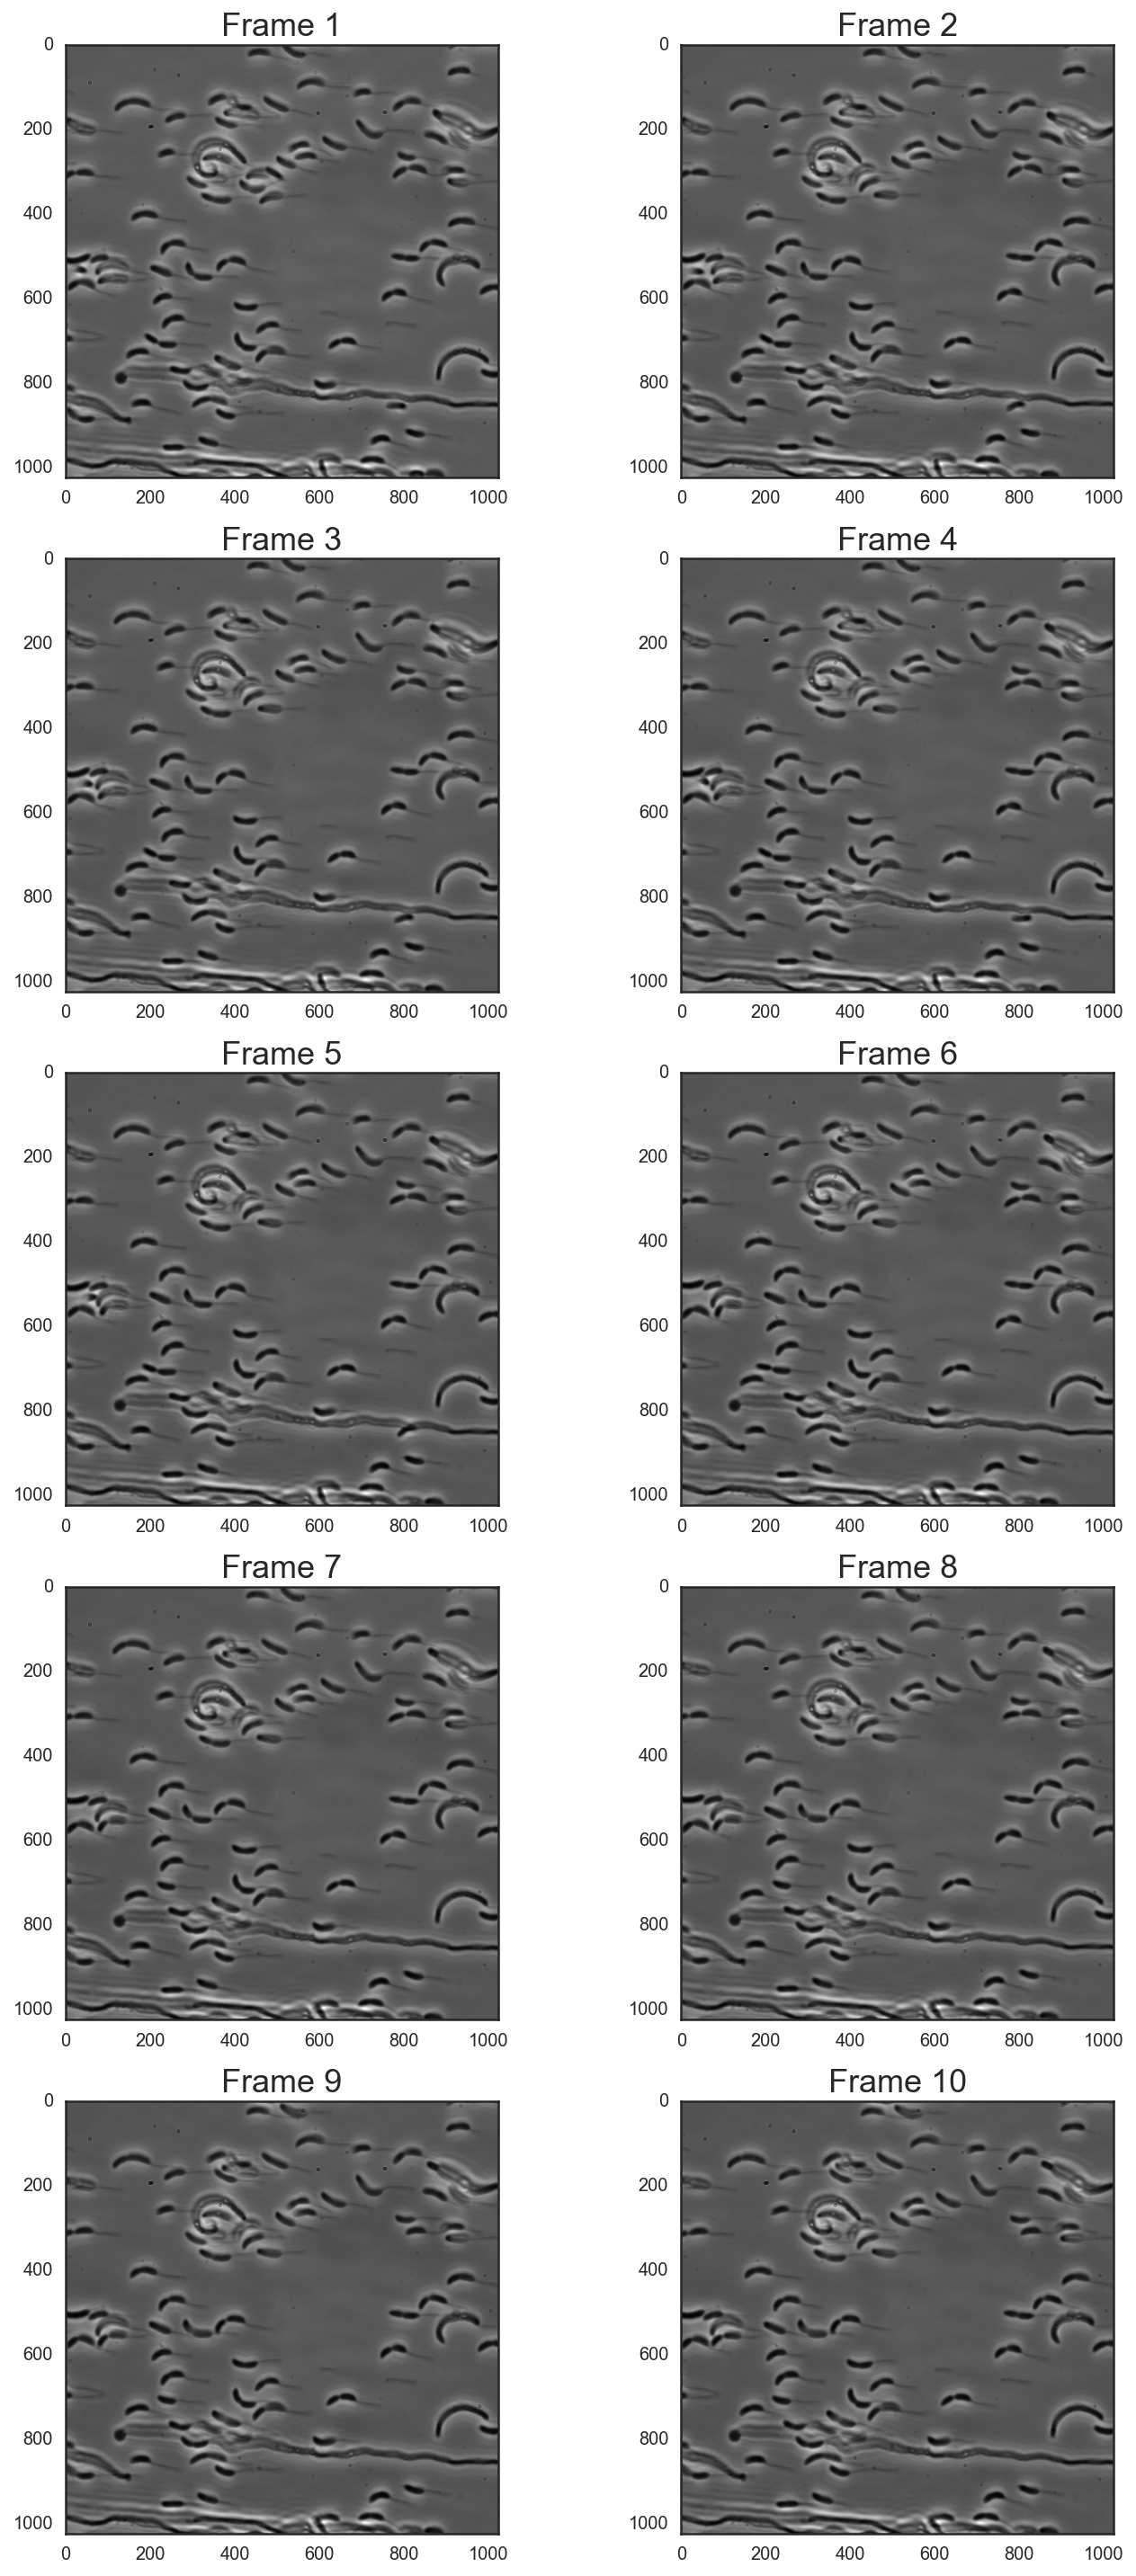

In [59]:
# Load the image stack
image_dir = './data/hw8_iyer-biswas_et_al\
/sequential_full_field/phase0300'

# Set up empty lists to hold the images
im_list = []
im_float_list = []

# Set up a figure for displaying the images
f = plt.figure(figsize=(10,20))

# Iterate through the stack and convert images to maximally stretched floats
for i in range(10):
    im_list.append(image_dir + str(i) + '.tif')

    im = skimage.io.imread(im_list[i])
    im_float_list.append((im.astype(float) - im.min()) / (im.max() - im.min()))

# Display the images    
for i in range(10):
    with sns.axes_style('white'):
        plt.subplot(5,2,i+1)
        plt.imshow(im_float_list[i], cmap=plt.cm.gray)
        plt.title('Frame ' + str(i+1))
plt.tight_layout()

Next let's segment the images. Since the frames look extremely similar, we will just work with the first one as an example. We decided to try Laplacian of Gaussian (LoG) with zero crossing detection. We used the same parameter values as what worked in tutorial 9b. 

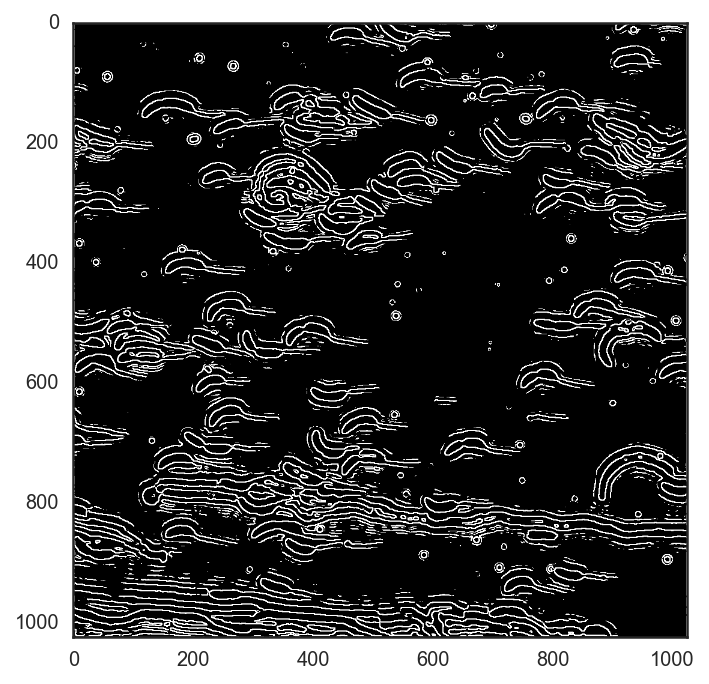

In [47]:
# Compute LoG
im_LoG = scipy.ndimage.filters.gaussian_laplace(im_float_list[0], 2.0)

def zero_crossing_filter(im, thresh):
    """
    Returns image with 1 if there is a zero crossing and 0 otherwise.
    
    thresh is the the minimal value of the gradient, as computed by Sobel
    filter, at crossing to count as a crossing.
    """
    # Square structuring element
    selem = skimage.morphology.square(3)
    
    # Do max filter and min filter
    im_max = scipy.ndimage.filters.maximum_filter(im, footprint=selem)
    im_min = scipy.ndimage.filters.minimum_filter(im, footprint=selem)
    
    # Compute gradients using Sobel filter
    im_grad = skimage.filters.sobel(im)
    
    # Return edges
    return (((im >= 0) & (im_min < 0)) | ((im <= 0) & (im_max > 0))) \
                & (im_grad >= thresh)

# Find zero-crossings
im_edge = zero_crossing_filter(im_LoG, 0.001)

# Show result
with sns.axes_style('white'):
    plt.imshow(im_edge, cmap=plt.cm.gray)

Clearly, we are detecting a lot more edges than just what belong to the bacteria. This makes sense, because most of the bacteria have a light-colored halo, which will yield high gradient values similar to the high gradients at the dark edges of the bacteria. However, it looks like we might be able to retain mostly individual bacteria and get rid of a lot of the extraneous noise if we close and fill, and filter out small objects.  

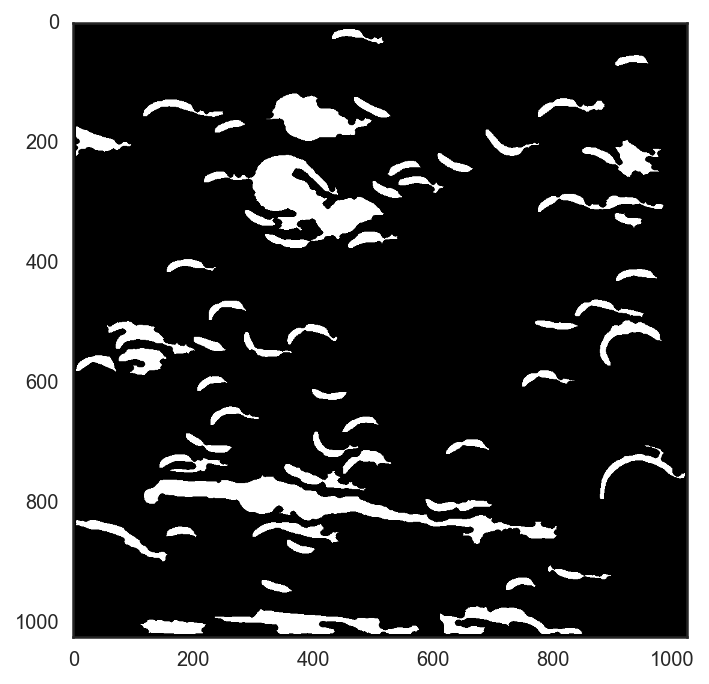

In [48]:
# Structuring element is radius 2 disk
selem = skimage.morphology.disk(2)

# Close binary image
im_bw_close = skimage.morphology.binary_closing(im_edge, selem)

# Remove small objectes that are not bacteria
im_bw = skimage.morphology.remove_small_objects(im_bw_close, min_size=500)

# Fill holes
im_bw = scipy.ndimage.morphology.binary_fill_holes(im_bw)

# Structuring element is radius 3 disk
selem = skimage.morphology.disk(3)

# Erode binary image again
im_bw_eroded = skimage.morphology.erosion(im_bw, selem)

# Remove small objectes that are not bacteria
im_bw = skimage.morphology.remove_small_objects(im_bw_eroded, min_size=500)

# Show result
with sns.axes_style('white'):
    fig = plt.imshow(im_bw, cmap=plt.cm.gray).get_figure()
    fig.savefig('output.png')

Indeed, we think this approach worked about as well as we could hope for, given the presence of bacterial clumps and non-bacterial objects. Although we did have to play around a bit to get there, it turns out that an extra erosion step and filtering twice to remove small objects gives pretty reasonable segmentation for many of the bacteria. 

The bacteria in the middle of the tail-like streak near the bottom of the frame (circled in cyan below) do not appear to be suitable for long time-course imaging. The tail-like streak causes problems when we try to segment the image; although the streak is part of the background, it is darker than the rest of the background and has a strong gradient around its edges, so it is distinguished as a cell in our segmentation. Other cells we believe are not suitable for gathering long time course imaging are exemplified by the bacteria circled in yellow below: segmentation fails when bacteria are clumped together. We suggest that the bacteria most suitable for long time course imaging are the bacteria that are relatively well-isolated from their neighbors. We have circled some of these bacteria in red below. 

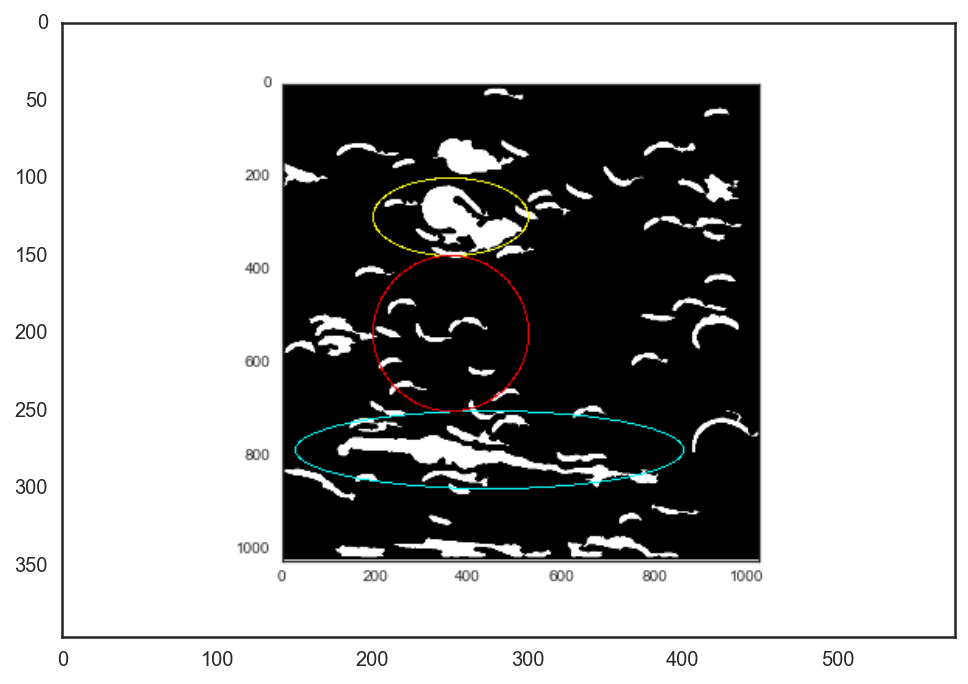

In [51]:
pic = Image.open('output.png')
draw = ImageDraw.Draw(pic)
draw.ellipse((150, 250, 400, 300), outline='cyan')
draw.ellipse((150+50, 100, 300, 150), outline='yellow')
draw.ellipse((200, 150, 300, 250), outline='red')
with sns.axes_style('white'):
    plt.imshow(pic)

# Part B

Let's load the image stacks and convert the frames to maximally stretched floats.

In [8]:
image_dir = './data/hw8_iyer-biswas_et_al/'
im_bac_1_file = os.path.join(image_dir, 'bacterium_1.tif')
im_bac_2_file = os.path.join(image_dir, 'bacterium_2.tif')

im_bac_1 = skimage.io.imread(im_bac_1_file)
im_bac_2 = skimage.io.imread(im_bac_2_file)

im_bac_1_float = np.empty(im_bac_1.shape)
for i in range(len(im_bac_1)):
    im_bac_1_float[i] = (im_bac_1[i].astype(float) - im_bac_1[i].min()) / (im_bac_1[i].max() - im_bac_1[i].min())

im_bac_2_float = np.empty(im_bac_2.shape)
for i in range(len(im_bac_2)):
    im_bac_2_float[i] = (im_bac_2[i].astype(float) - im_bac_2[i].min()) / (im_bac_2[i].max() - im_bac_2[i].min())

We also defined a function to streamline the segmentation process. We optimized the parameters for bacterium 1 and bacterium 2 through trial and error, settling on the values below as the ones that gave the most accurate segmentation for the greatest number of frames in each stack. 

In [62]:
def segment_bacteria(im, bac):
    """
    Segments an image of bacteria using Laplacian
    of Gaussian with zero crossing detection.
    """
    if bac == 1:
        gaussian_blur = 3.0
        zero_crossing_thresh = 0.002
        selem_size = 4
    elif bac == 2:
        gaussian_blur = 5.0
        zero_crossing_thresh = 0.0008
        selem_size = 5
        
    # Compute LoG
    im_LoG = scipy.ndimage.filters.gaussian_laplace(im, gaussian_blur)

    # Find zero-crossings
    im_edge = zero_crossing_filter(im_LoG, zero_crossing_thresh)

    # Structuring element is radius 2 disk
    selem = skimage.morphology.disk(selem_size)

    # Close binary image
    im_bw_close = skimage.morphology.binary_closing(im_edge, selem)

    im_skel = skimage.morphology.skeletonize(im_bw_close)

    # Fill holes
    im_bw = scipy.ndimage.morphology.binary_fill_holes(im_skel)

    # Remove small objectes that are not bacteria
    im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=50)

    return im_bw

Next, we combined the segmentation function with image labeling and `skimage.measure.regionprops` to obtain the area of the parent bacterium over time. We assumed that the parent bacterium would always be the largest bacterium when there is more than one bacterium in the frame. We manually checked this assumption for a few frames, and it seemed to be generally valid.

**Bacterium 1**

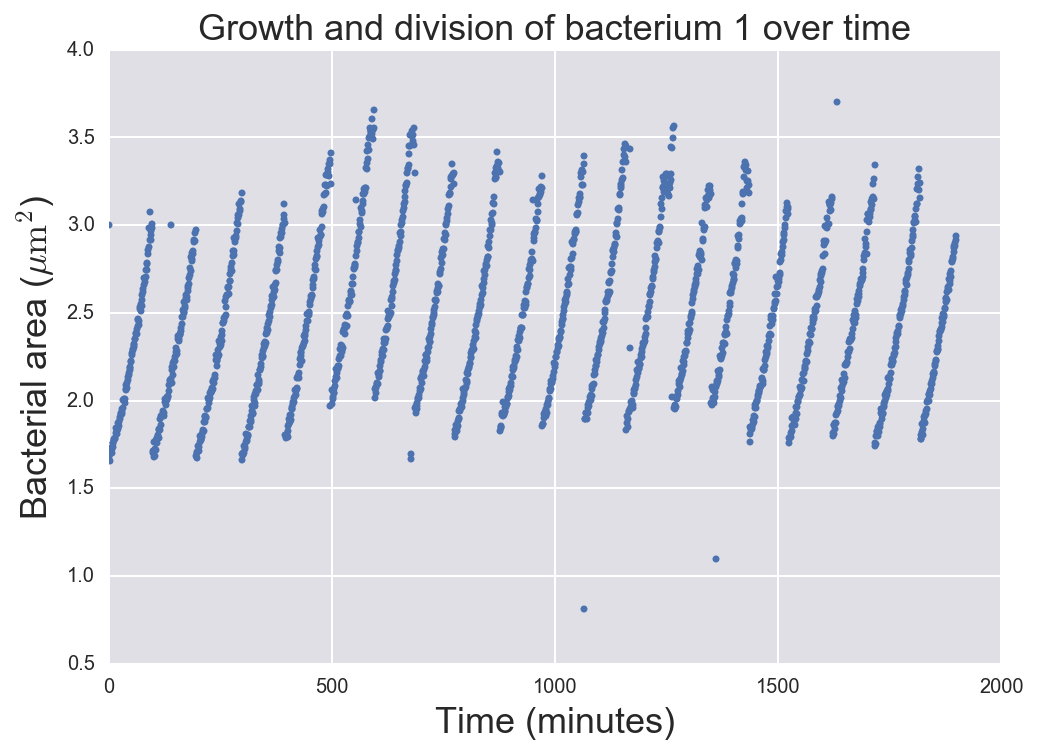

In [73]:
# Set the initial max_area to a value that all bacteria should surpass
max_area = np.array([0.01] * len(im_bac_1_float))

for i in range(len(im_bac_1_float)):    
    im_bw = segment_bacteria(im_bac_1_float[i], 1)
    
    # Label binary image
    im_labeled, n_labels = skimage.measure.label(im_bw, background=-1, return_num=True)

    # Get area of each bacterium and store the largest area in case of more than one bacterium
    physical_size = 0.052
    im_props = skimage.measure.regionprops(im_labeled)
    
    for prop in im_props:
        if prop.area * physical_size**2 > max_area[i]:
            max_area[i] = prop.area * physical_size**2

plt.plot(np.arange(len(im_bac_1_float)), max_area, '.')
plt.title('Growth and division of bacterium 1 over time')
plt.xlabel('Time (minutes)')
plt.ylabel(r'Bacterial area ($\mathrm{\mu m^2}$)')

This actually doesn't look too bad, but there are definitely a few outliers. Before throwing them out, we wanted to check a couple of the outlier frames to see what was going on.

In [63]:
# Find the frames where the bacteria is reported as smaller than
# we would expect
too_small = np.where(max_area < 1.5)
print('too small: ' + str(too_small))

too small: (array([1066, 1361]),)


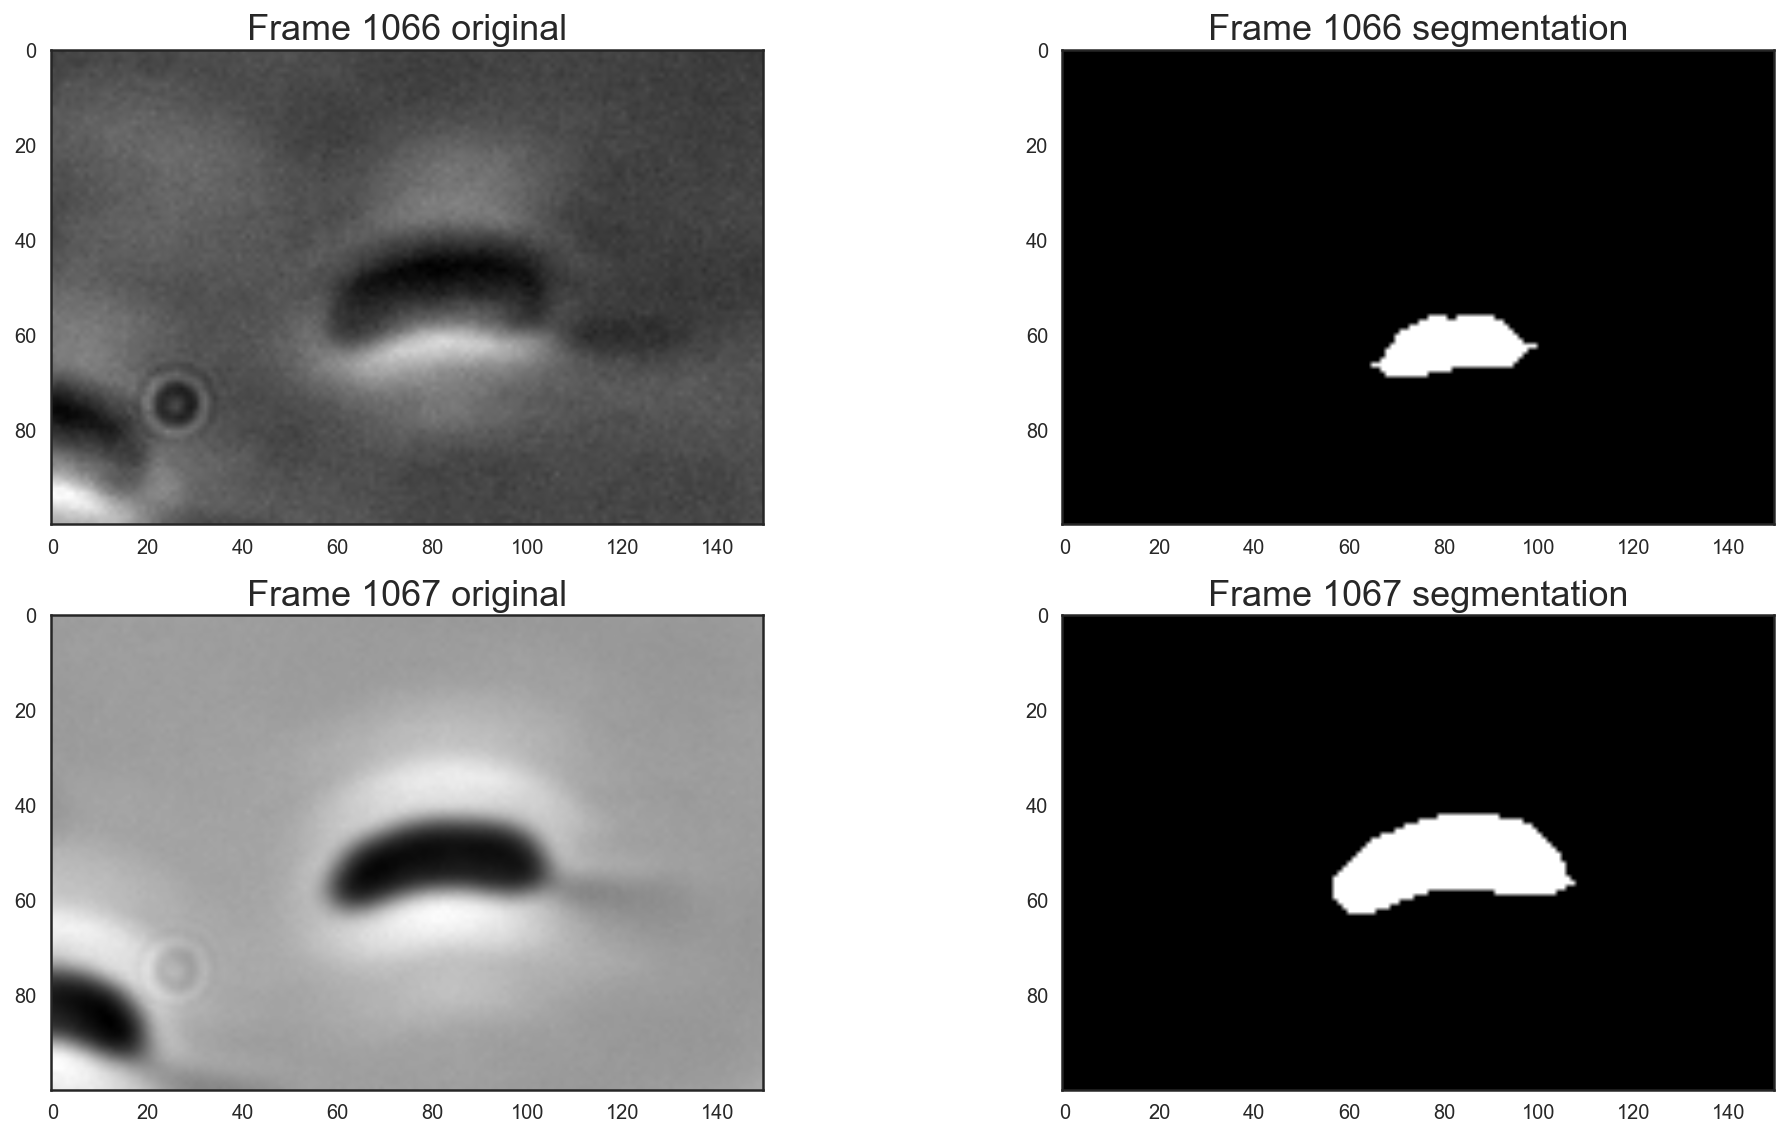

In [64]:
# Display the original and segmented images for an outlier
# and a normal frame
inds = [1066, 1067]
im_bw = np.empty((2, 100, 150))
im_orig = np.empty((2, 100, 150))
for ind, i in enumerate(inds):
    im_bw[ind] = segment_bacteria(im_bac_1_float[i], 1)
    im_orig[ind] = im_bac_1_float[i]
    
with sns.axes_style('white'):
    f = plt.figure(figsize=(15,8))    
    plt.subplot(2,2,1)
    plt.imshow(im_orig[0], cmap=plt.cm.gray)
    plt.title('Frame 1066 original')
    plt.subplot(2,2,2)
    plt.imshow(im_bw[0], cmap=plt.cm.gray)
    plt.title('Frame 1066 segmentation')
    plt.subplot(2,2,3)
    plt.imshow(im_orig[1], cmap=plt.cm.gray)
    plt.title('Frame 1067 original')
    plt.subplot(2,2,4)
    plt.title('Frame 1067 segmentation')
    plt.imshow(im_bw[1], cmap=plt.cm.gray)
    plt.tight_layout()

Sure enough, it looks like our segmentation method isn't ideal for frame 1066, probably because the boundary of the bacterium is much fuzzier and the background is also closer to the shade of the bacterium. Unfortunately, using frame 1066 as the basis for optimizing the parameters for LoG / zero crossing detection didn't give satisfactory results for many other frames in the stack (not shown). Thus, we decided to simply drop frames like 1066 where our segmentation method failed to accurately represent the image. Our criteria for dropping was based on finding frames where there was a large positive jump in bacterial area. Such jumps generally indicate segmentation errors, since the bacteria cannot physically fluctuate in size that rapidly and to that degree. When dropping frames, we made sure to drop the corresponding time-points as well in order to maintain accurate calculations of inter-divison times in subsequent steps.

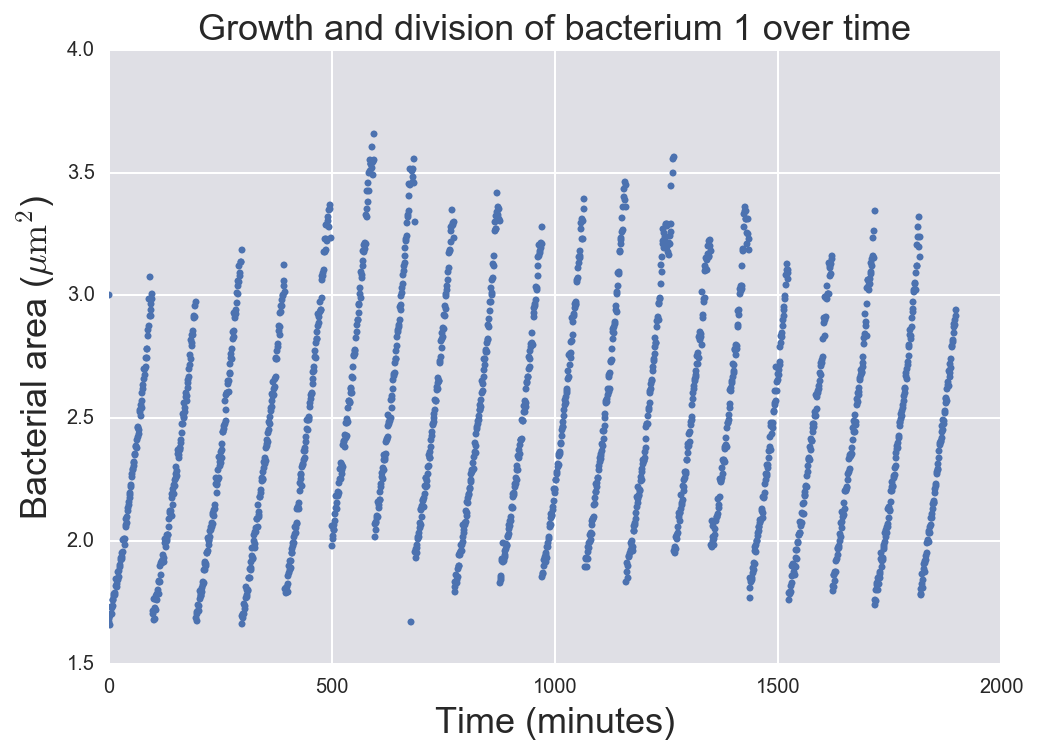

In [74]:
# Copy the array of max areas in case we need the original later
new_max_area = np.copy(max_area)

# Drop outliers, which we define as points where the jump to the next point
# is greater than +0.3 µM^2
area_diff = np.concatenate((np.array([0.1]), np.diff(new_max_area)))
new_areas = new_max_area[area_diff < 0.3]
new_area_diff = np.concatenate((np.diff(new_areas), np.array([0.1])))
new_areas = new_areas[new_area_diff < 0.3]
times = np.arange(len(new_max_area))[area_diff < 0.3]
times = times[new_area_diff < 0.3]

# Take a look
plt.plot(times, new_areas, '.')
plt.title('Growth and division of bacterium 1 over time')
plt.xlabel('Time (minutes)')
plt.ylabel(r'Bacterial area ($\mathrm{\mu m^2}$)')

We think this looks much cleaner -- most of what we by eye might consider outliers has disappeared. Now we can determine the time of each division event and calculate the inter-divison times.

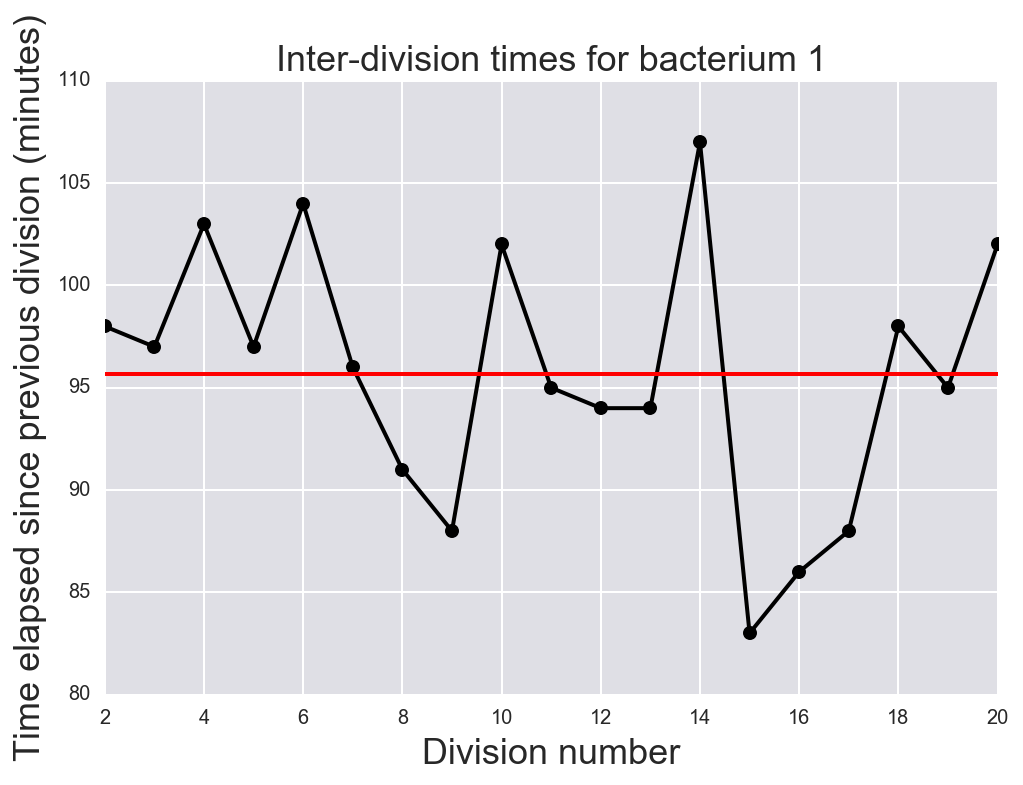

In [76]:
# Calculate the difference in bacteria area between consecutive frames
# Add something to the end of the array to maintain the array length
final_area_diffs = np.concatenate((np.diff(new_areas), np.array([0.1])))

# Divisions are marked by a large negative jump in bacterial area
inter_div_inds = times[final_area_diffs < -1.0]

# Filter out "division events" that occur too soon after a previous division
# (likely identified as a division event due to remaining errors/noise 
# in segmentation)
inter_div_inds_list = []
for i in np.arange(1, len(inter_div_inds)):
    if inter_div_inds[i] - inter_div_inds[i-1] > 50:
        inter_div_inds_list.append(inter_div_inds[i-1])
# Make sure to keep the last frame unless it is a "bad" division event
if inter_div_inds[-1] - inter_div_inds[-2] > 50:
    inter_div_inds_list.append(inter_div_inds[-1])
inter_div_inds = np.array(inter_div_inds_list) 

# Calculate the inter-division times (in minutes)
inter_div_time = np.diff(inter_div_inds)

# Plot the inter-division times along with the mean inter-division time
plt.plot(np.arange(len(inter_div_time))+2, 
         inter_div_time, marker='o', color='k')
plt.plot(np.arange(len(inter_div_time))+2, 
         [np.mean(inter_div_time)] * len(inter_div_time), color='r')
plt.title('Inter-division times for bacterium 1')
plt.xlabel('Division number')
plt.ylabel('Time elapsed since previous division (minutes)')

It looks like the inter-division times oscillate around a mean of just over 95 minutes, plus or minus ~10 minutes. We don't think there are enough datapoints to tell whether the oscillation has a regular period. However, it does seem like particularly short or long inter-division times tend to be compensated within a few subsequent divisions, by longer or shorter inter-division times respectively. Perhaps if a bacterium divides on the early side and ends up smaller than it started, it needs more time to get back to a target size in subsequent growth periods.    

**Bacterium 2**

We repeat the same procedures as for bacterium 1, but with slightly different values for some segmetation parameters.

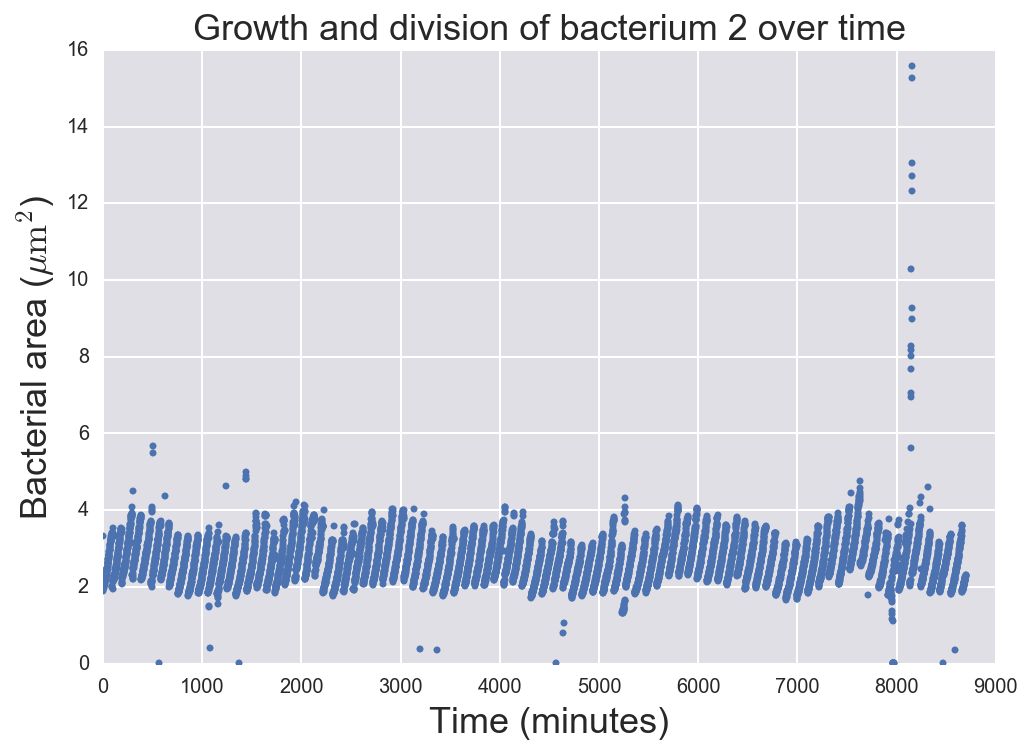

In [77]:
max_area2 = np.array([0.01] * len(im_bac_2_float))
for i in range(len(im_bac_2_float)):
    im_bw = segment_bacteria(im_bac_2_float[i], 2)
    # Label binary image
    im_labeled, n_labels = skimage.measure.label(im_bw, background=-1, return_num=True)

    # Get area of each bacterium and store the largest area in case of more than one bacterium
    physical_size = 0.052
    im_props = skimage.measure.regionprops(im_labeled)
    for prop in im_props:
        if prop.area * physical_size**2 > max_area2[i]:
            max_area2[i] = prop.area * physical_size**2

plt.plot(np.arange(len(im_bac_2_float)), max_area2, '.')
plt.title('Growth and division of bacterium 2 over time')
plt.xlabel('Time (minutes)')
plt.ylabel(r'Bacterial area ($\mathrm{\mu m^2}$)')

Once again, there are definitely outliers! Let's look at a couple of them.

In [16]:
too_big = np.where(max_area2 > 6)
too_small = np.where(max_area2 < 1)

print('too big: ' + str(too_big))
print('too small: ' + str(too_small))

too big: (array([8142, 8143, 8146, 8147, 8148, 8149, 8150, 8151, 8152, 8153, 8154,
       8155, 8156, 8157]),)
too small: (array([ 568, 1080, 1375, 3195, 3368, 4568, 4642, 7961, 7962, 7963, 7964,
       7965, 7969, 7970, 7979, 8471, 8591]),)


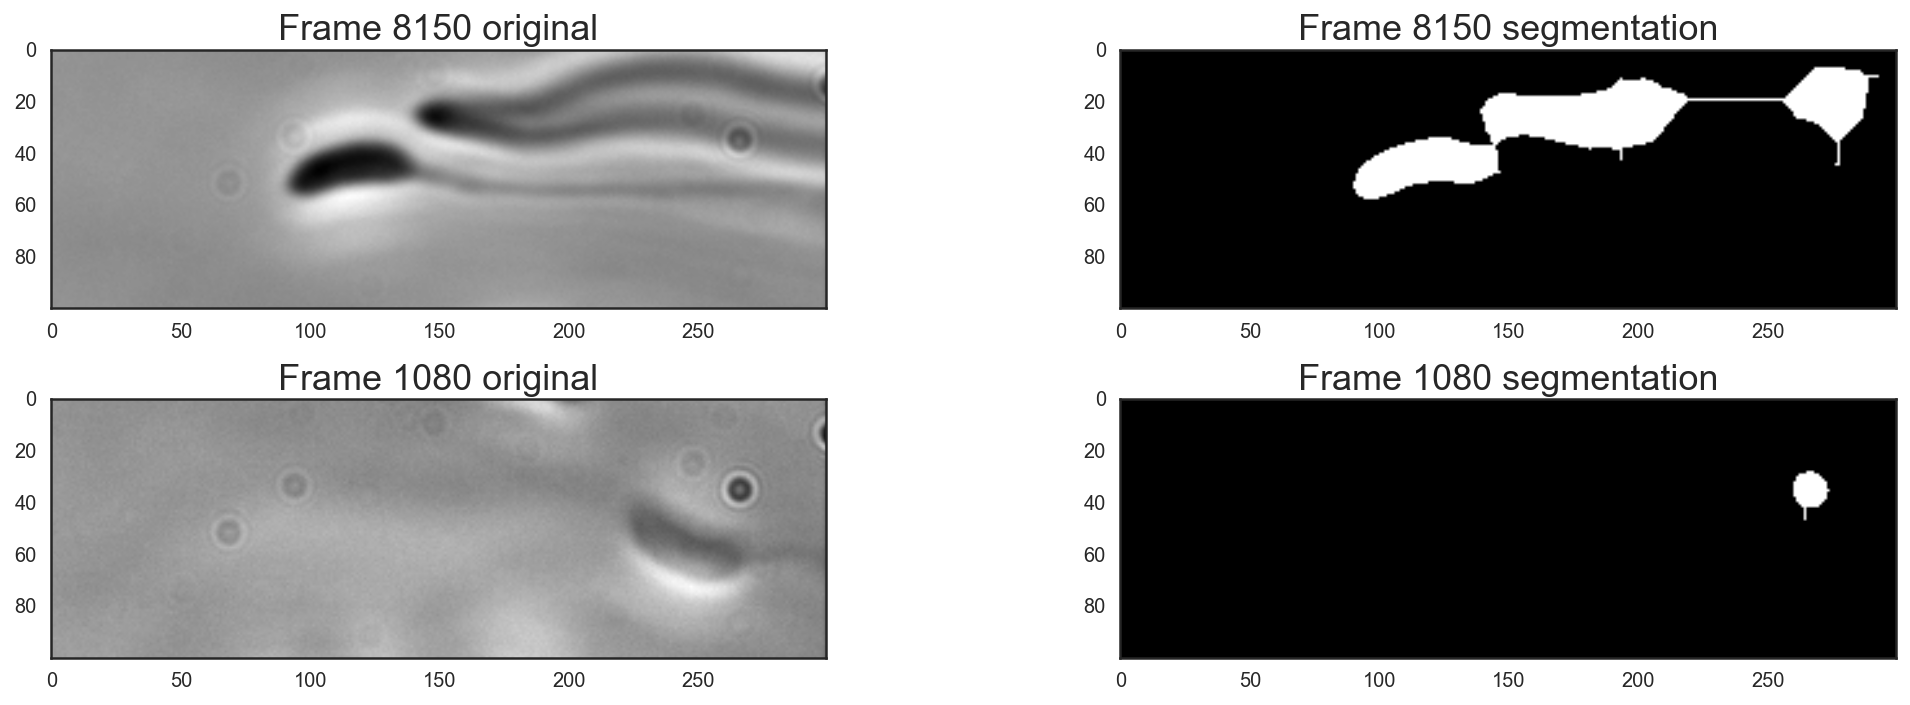

In [17]:
bad_inds = [8150, 1080]
im_bw = np.empty((2, 100, 300))
im_orig = np.empty((2, 100, 300))
for ind, i in enumerate(bad_inds):
    im_bw[ind] = segment_bacteria(im_bac_2_float[i], 2)
    im_orig[ind] = im_bac_2_float[i]
    
with sns.axes_style('white'):
    f = plt.figure(figsize=(15,5))    
    plt.subplot(2,2,1)
    plt.imshow(im_orig[0], cmap=plt.cm.gray)
    plt.title('Frame 8150 original')
    plt.subplot(2,2,2)
    plt.imshow(im_bw[0], cmap=plt.cm.gray)
    plt.title('Frame 8150 segmentation')
    plt.subplot(2,2,3)
    plt.imshow(im_orig[1], cmap=plt.cm.gray)
    plt.title('Frame 1080 original')
    plt.subplot(2,2,4)
    plt.imshow(im_bw[1], cmap=plt.cm.gray)
    plt.title('Frame 1080 segmentation')
    plt.tight_layout()

We looked at even more than these, but basically, it is pretty clear that the outliers are due to failures in segmentation, so we feel comfortable dropping them (other segmentation methods just created even more outliers). 

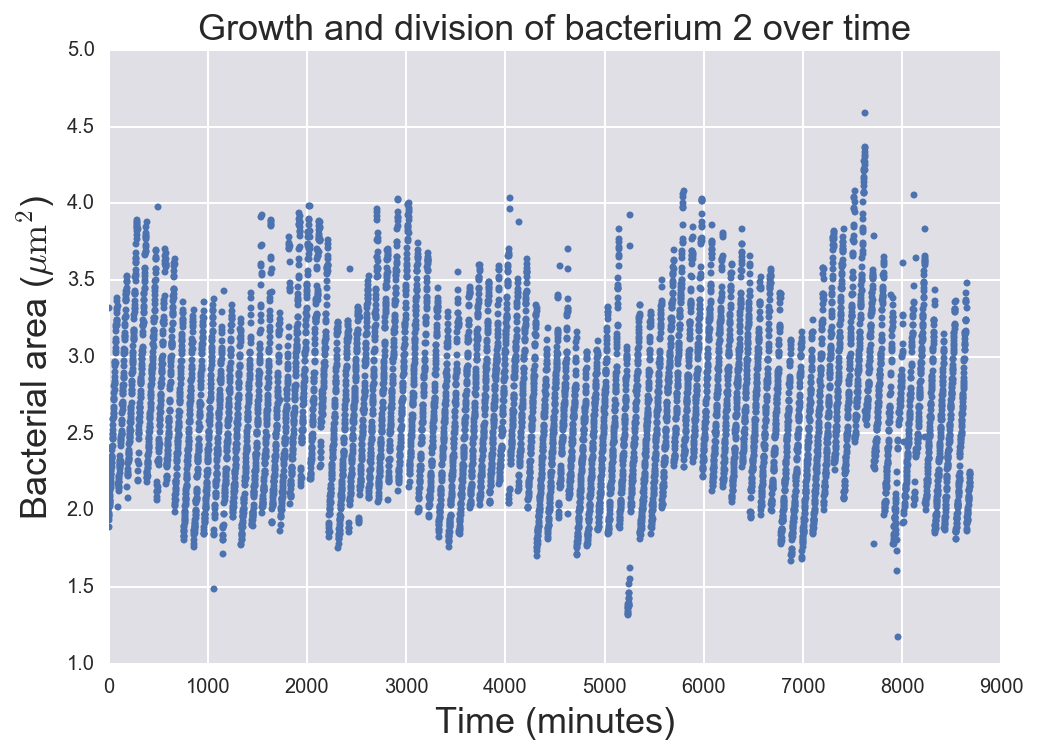

In [79]:
# Copy the array of max areas in case we need the original later
new_max_area2 = np.copy(max_area2)

# Drop outliers, which we define as points where the jump to the next point
# is greater than +0.3
area_diff2 = np.concatenate((np.array([0.1]), np.diff(new_max_area2, n=3)))
new_areas2 = new_max_area2[area_diff2 < 0.3]
new_area_diff2 = np.concatenate((np.diff(new_areas2, n=3), np.array([0.1])))
new_areas2 = new_areas2[new_area_diff2 < 0.3]
# Also drop all remaining frames where the area is greater than 
# 5 or less than 1
new_areas2 = new_areas2[new_areas2 < 5]
new_areas2 = new_areas2[new_areas2 > 1]
times2 = np.arange(len(new_max_area2))[area_diff2 < 0.3]
times2 = times2[new_area_diff2 < 0.3]
times2 = times2[new_areas2 < 5]
times2 = times2[new_areas2 > 1]

# Take a look
plt.plot(times2, new_areas2, '.')
plt.title('Growth and division of bacterium 2 over time')
plt.xlabel('Time (minutes)')
plt.ylabel(r'Bacterial area ($\mathrm{\mu m^2}$)')

This still isn't "perfect" but it definitely looks better and we think it will be good enough for our purposes.

As before, we calculate and plot the inter-division times.

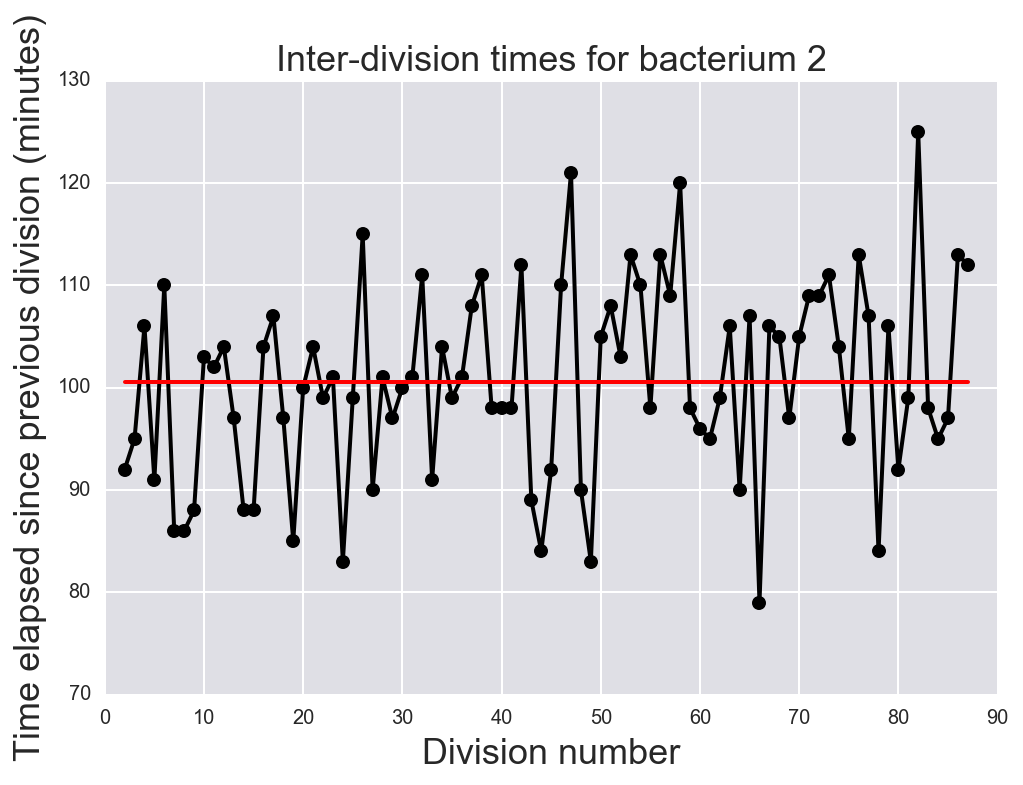

In [81]:
# Calculate the difference in bacteria area between consecutive frames
# Add something to the end of the array to maintain the array length
final_area_diffs2 = np.concatenate((np.diff(new_areas2), np.array([0.1])))

# Divisions are marked by a large negative jump in bacterial area
inter_div_inds2 = times2[final_area_diffs2 < -1.2]

# Filter out "division events" that occur too soon after a previous division
# (likely identified as a division event due to remaining errors/noise 
# in segmentation)
inter_div_inds_list2 = []
for i in np.arange(1, len(inter_div_inds2)):
    if inter_div_inds2[i] - inter_div_inds2[i-1] > 50:
        inter_div_inds_list2.append(inter_div_inds2[i-1])
# Make sure to keep the last frame unless it is a "bad" division event
if inter_div_inds2[-1] - inter_div_inds2[-2] > 50:
    inter_div_inds_list2.append(inter_div_inds2[-1])
inter_div_inds2 = np.array(inter_div_inds_list2) 

# Calculate the inter-division times (in minutes)
inter_div_time2 = np.diff(inter_div_inds2)

# Plot the inter-division times along with the mean inter-division time
plt.plot(np.arange(len(inter_div_time2))+2, 
         inter_div_time2, marker='o', color='k')
plt.plot(np.arange(len(inter_div_time2))+2, 
         [np.mean(inter_div_time2)]*len(inter_div_time2), color='r')
plt.title('Inter-division times for bacterium 2')
plt.xlabel('Division number')
plt.ylabel('Time elapsed since previous division (minutes)')

Similar to bacterium 1, we see oscillation around the mean inter-division time. The mean inter-division time is a bit higher than for bacterium 1, by about 5 minutes. The range is also greater, plus or minus ~20 minutes from the mean. This might reflect a real difference between bacterium 1 and bacterium 2, but it is also possible that we would have seen a wider range of inter-divison times for bacterium 1 if it was observed over as long a time-course as bacterium 2. 

# Part C

First, we generate a list of area-series and time-series for each bacterium, where each pair of area- and time-series corresponds to a single growth curve (growth in the time between two divisions). We will use these series as our inputs for model selection via PTMCMC.

In [21]:
# Find the indices of the division events
inter_div_inds = np.where(final_area_diffs < -1.0)[0]
inter_div_inds_list = []
for i in np.arange(1, len(inter_div_inds)):
    if inter_div_inds[i] - inter_div_inds[i-1] > 50:
        inter_div_inds_list.append(inter_div_inds[i-1])
if inter_div_inds[-1] - inter_div_inds[-2] > 50:
    inter_div_inds_list.append(inter_div_inds[-1])
inter_div_inds = np.array(inter_div_inds_list) 
inds1 = inter_div_inds + 1

# Iterate over the division events to split the area
# and time data into inter-division slices
init_areas1 = np.empty(len(inds1))
for i, ind in enumerate(inds1):
    init_areas1[i] = new_areas[ind]
inds1 = np.concatenate((inds1, np.array([len(new_areas)-1])))
area_series1 = []
time_series1 = []
for i in range(len(inds1)-1):
    area_series1.append(new_areas[inds1[i]:inds1[i+1]])
    time_series1.append(times[inds1[i]:inds1[i+1]] - times[inds1[i]])
    
# Repeat the above procedures for bacterium 2
inter_div_inds2 = np.where(final_area_diffs2 < -1.2)[0]
inter_div_inds_list2 = []
for i in np.arange(1, len(inter_div_inds2)):
    if inter_div_inds2[i] - inter_div_inds2[i-1] > 50:
        inter_div_inds_list2.append(inter_div_inds2[i-1])
if inter_div_inds2[-1] - inter_div_inds2[-2] > 50:
    inter_div_inds_list2.append(inter_div_inds2[-1])
inter_div_inds2 = np.array(inter_div_inds_list2)
inds2 = inter_div_inds2 + 1
init_areas2 = np.empty(len(inds2))
for i, ind in enumerate(inds2):
    init_areas2[i] = new_areas2[ind]
inds2 = np.concatenate((inds2, np.array([len(new_areas2)-1])))
area_series2 = []
time_series2 = []
for i in range(len(inds2)-1):
    area_series2.append(new_areas2[inds2[i]:inds2[i+1]])
    time_series2.append(times2[inds2[i]:inds2[i+1]] - times2[inds2[i]])


Next we define the functions we need to run PTMCMC. We have two theoretical models we want to compare:

\begin{align}
\mathrm{Linear:} \,\,\,\,\, a(t) = a_0 + bt \\
\mathrm{Exponential:} \,\,\,\,\, a(t) = a_0 \mathrm{e}^{\kappa t}
\end{align}

For the log likelihood, we use a Student t distribution (i.e. a Gaussian distribution marginalized over $\sigma$, since we assume the errors are Gaussian distributed according to the central limit theorem and we are not concerned with estimating $\sigma$). For the prior, we assume Jeffreys priors for $\kappa$ and $b$ since they are scale parameters, and a uniform prior for $a_0$ since it is a location parameter. 

In [22]:
def exp_theor(params, times):
    a_0, k  = params
    return a_0 * np.exp(k * times)

def lin_theor(params, times):
    a_0, b = params
    return a_0 + b * times

def log_like(params, times, areas, model):
    
    if model == 'lin_theor':  
        a_0, b = params
        areas_theor = lin_theor(params, times)
    elif model == 'exp_theor':
        a_0, k = params
        areas_theor = exp_theor(params, times)
    return -len(times) / 2 * np.log(np.sum((areas - areas_theor)**2))

def log_prior(params, model, a_max=4, a_min=1e-6, k_max=0.01, k_min=1e-6, b_max=1, b_min=1e-6):
    if model == 'exp_theor':
        a_0, k = params
        if a_0 < a_min or a_0 > a_max or k < k_min or k > k_max:
            return -np.inf
        prior = k * np.log(k_max / k_min)
        return -np.log(prior)
       
    elif model == 'lin_theor':
        a_0, b = params
        if a_0 < a_min or a_0 > a_max or b < b_min or b > b_max:
            return -np.inf
        prior = b * np.log(b_max / b_min)
        return -np.log(prior)
    
def params_start(n_walkers, n_temps, model, a_max=4, a_min=1e-6,
                 k_max=0.01, k_min=1e-6, b_max=0.1, b_min=1e-6, n_dim=2):
    """
    Generates starting points for each tau.
    """
    params = np.empty((n_temps, n_walkers, n_dim))
    
    if model == 'exp_theor':
        params[:,:,0] = np.random.uniform(a_min, a_max, (n_temps,n_walkers))
        params[:,:,1] = np.random.uniform(k_min, k_max, (n_temps,n_walkers))
    elif model == 'lin_theor':
        params[:,:,0] = np.random.uniform(a_min, a_max, (n_temps,n_walkers))
        params[:,:,1] = np.random.uniform(b_min, b_max, (n_temps,n_walkers))
    return params

We define a function to help us run PTMCMC.

In [23]:
def sample_ptmcmc(times, areas, model, n_temps=20, n_walkers=100, n_burn=100, 
                  n_steps=500, threads=None):
    """
    Sample posterior using PTMCMC.
    """
    # arguments for likelihood
    loglargs = (times, areas, model)
    
    # arguments for prior
    logpargs = (model,)
    
    # starting points for the parameters
    p0 = params_start(n_walkers, n_temps, model)
    
    # column headings for outputted DataFrames
    columns = {'lin_theor': ['a_0', 'b'],
               'exp_theor': ['a_0', 'k']}
    
    return bebi103.run_pt_emcee(
            log_like, log_prior, n_burn, n_steps,
            n_temps=n_temps, p0=p0, loglargs=loglargs, logpargs=logpargs,
            threads=threads, columns=columns[model], return_lnZ=True)

We ran PTMCMC for both models. Doing so for all of the growth curves would have taken a lot of computational time and resources, so we instead chose three representative growth curves for bacterium 1 to get a sense for whether one model is consistently favored. 

In [24]:
start = time.time()
df_1_lin, lnZ_1_lin, dlnZ_1_lin = sample_ptmcmc(time_series1[1], area_series1[1], 'lin_theor', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=200, n_steps=1000, threads=3)
print('PTMCMC took', time.time()-start, ' seconds.')

start = time.time()
df_9_lin, lnZ_9_lin, dlnZ_9_lin = sample_ptmcmc(time_series1[9], area_series1[9], 'lin_theor', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=200, n_steps=1000, threads=3)
print('PTMCMC took', time.time()-start, ' seconds.')

start = time.time()
df_16_lin, lnZ_16_lin, dlnZ_16_lin = sample_ptmcmc(time_series1[16], area_series1[16], 'lin_theor', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=200, n_steps=1000, threads=3)
print('PTMCMC took', time.time()-start, ' seconds.')

start = time.time()
df_1_exp, lnZ_1_exp, dlnZ_1_exp = sample_ptmcmc(time_series1[1], area_series1[1], 'exp_theor', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=200, n_steps=1000, threads=3)
print('PTMCMC took', time.time()-start, ' seconds.')

start = time.time()
df_9_exp, lnZ_9_exp, dlnZ_9_exp = sample_ptmcmc(time_series1[9], area_series1[9], 'exp_theor', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=200, n_steps=1000, threads=3)
print('PTMCMC took', time.time()-start, ' seconds.')

start = time.time()
df_16_exp, lnZ_16_exp, dlnZ_16_exp = sample_ptmcmc(time_series1[16], area_series1[16], 'exp_theor', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=200, n_steps=1000, threads=3)
print('PTMCMC took', time.time()-start, ' seconds.')

PTMCMC took 44.42778301239014  seconds.
PTMCMC took 43.09247589111328  seconds.
PTMCMC took 47.330065965652466  seconds.
PTMCMC took 47.68888282775879  seconds.
PTMCMC took 48.31976389884949  seconds.
PTMCMC took 44.89281511306763  seconds.


We quickly checked the `corner` plots to make sure we got reasonable-looking posterior distributions. (To save space, we are only showing the `corner` plots for the first growth curve we looked at.) 

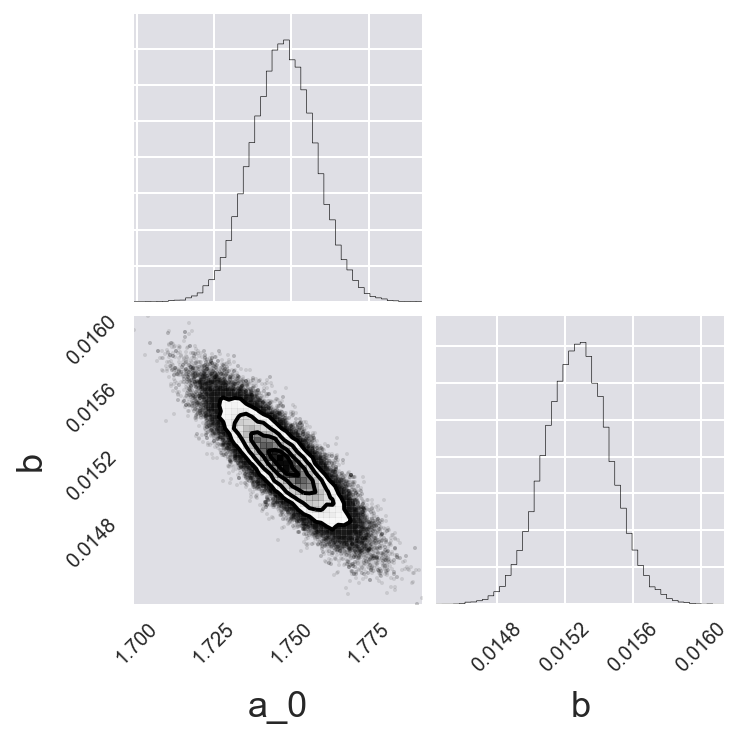

In [25]:
_ = corner.corner(df_1_lin[df_1_lin.beta_ind==0][['a_0', 'b']], bins=50)

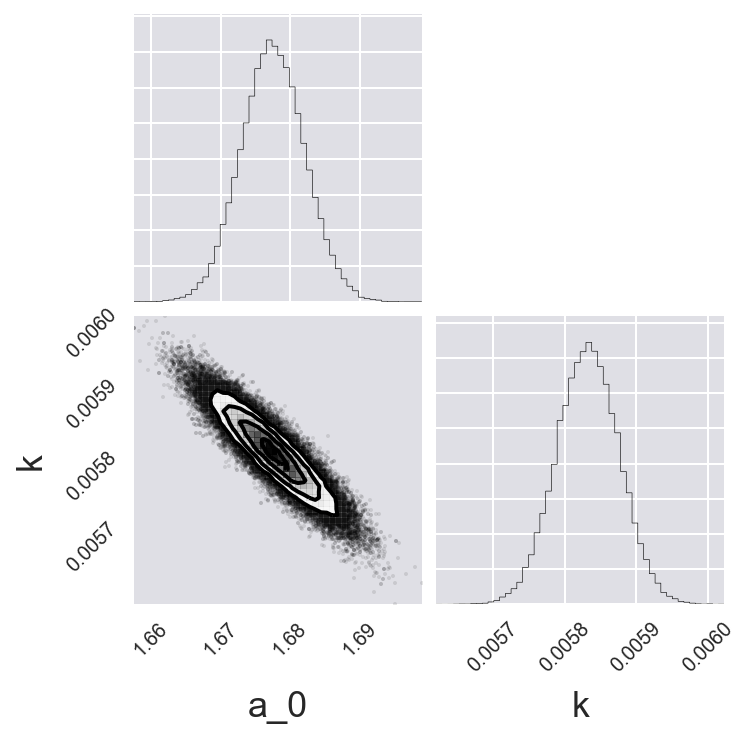

In [39]:
_ = corner.corner(df_1_exp[df_1_exp.beta_ind==0][['a_0', 'k']], bins=50)

The `corner` plots looked good, so we found the parameter values at the MAP and used those to plot the theoretical models on top of the raw data.

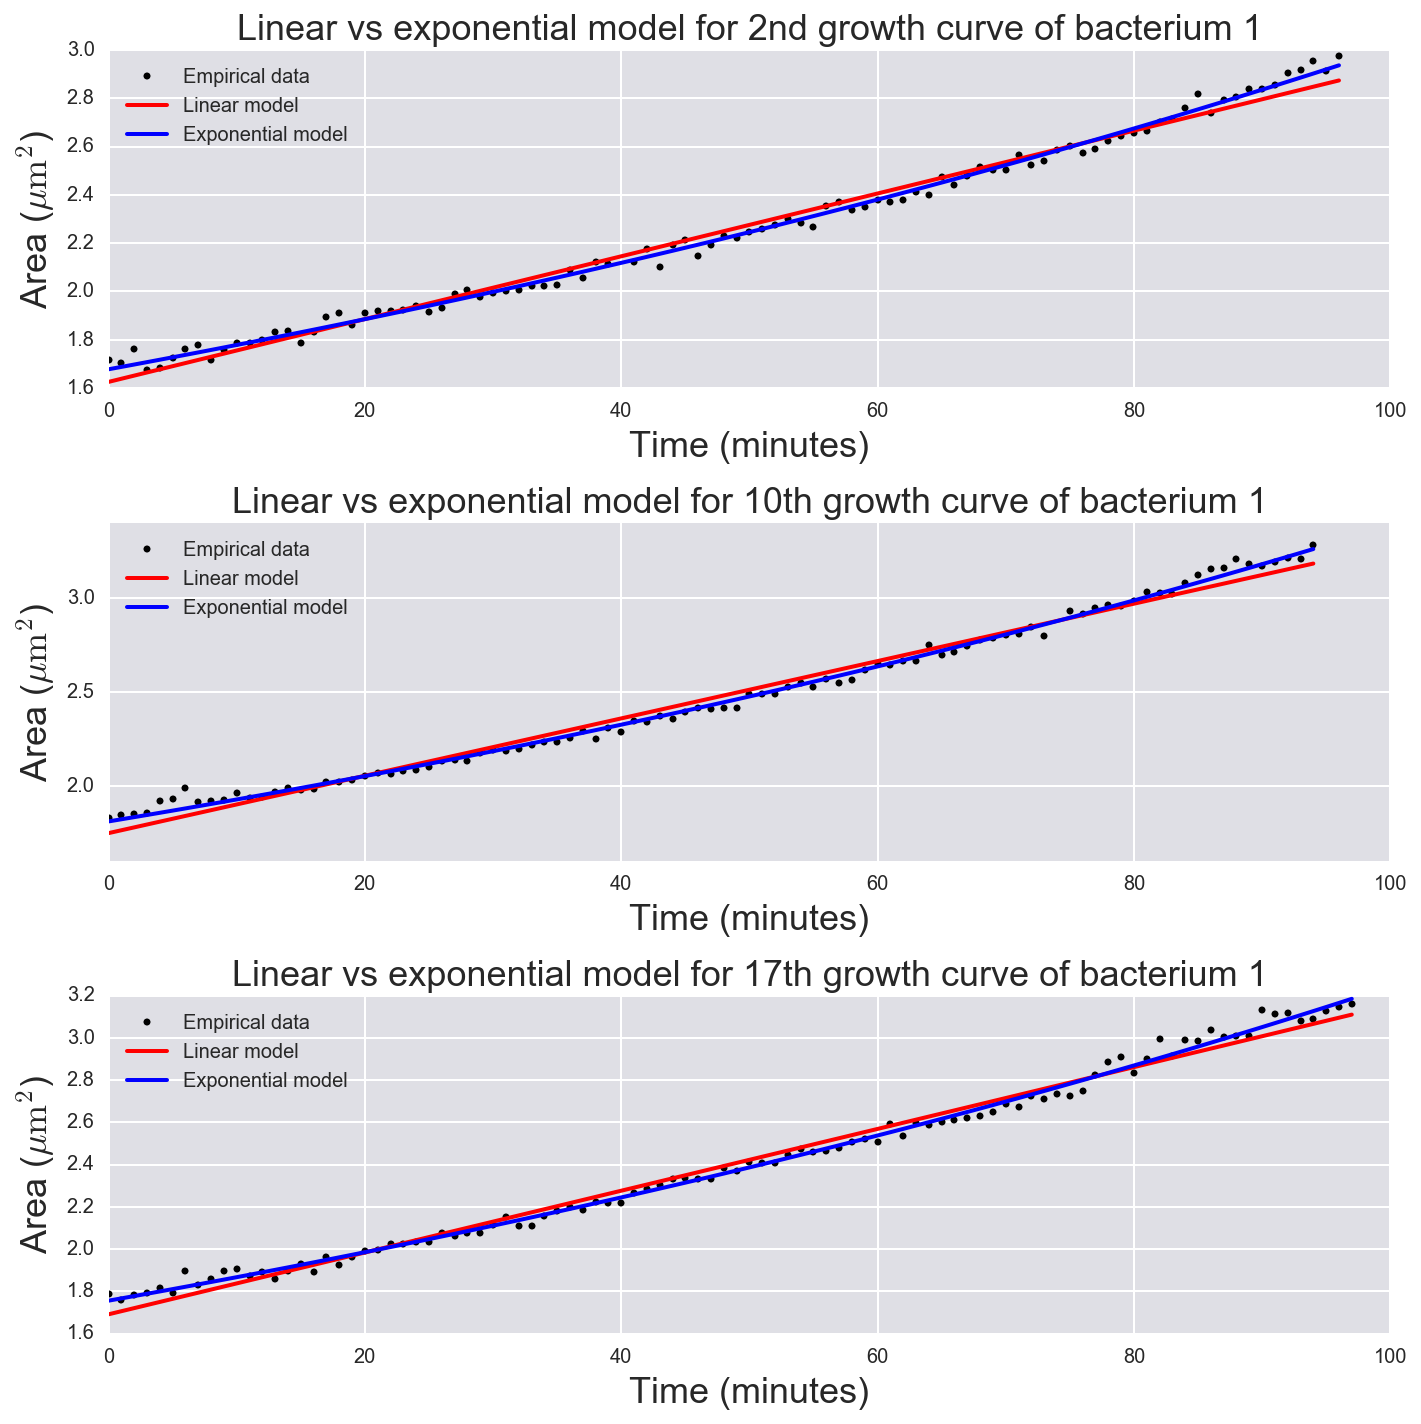

In [37]:
df_list = [df_1_lin, df_1_exp, df_9_lin, df_9_exp, df_16_lin, df_16_exp]
map1_bac1 = []
map2_bac1 = []

for i in range(len(df_list)):
    # Get the index of the most probable parameter set
    df_map = df_list[i][df_list[i].beta_ind == 0]
    max_ind = np.argmax(df_map.lnprob.values)

    # Pull out values.
    map_1, map_2 = df_map.values[max_ind, :2]
    map1_bac1.append(map_1)
    map2_bac1.append(map_2)

f = plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.plot(time_series1[1], area_series1[1], '.', color='k')
plt.plot(time_series1[1],
         lin_theor(np.array([map1_bac1[0], map2_bac1[0]]), time_series1[1]), color='r')
plt.plot(time_series1[1],
         exp_theor(np.array([map1_bac1[1], map2_bac1[1]]), time_series1[1]), color='b')
plt.title('Linear vs exponential model for 2nd growth curve of bacterium 1')
plt.xlabel('Time (minutes)')
plt.ylabel(r'Area ($\mathrm{\mu m^2}$)')
plt.legend(['Empirical data', 'Linear model', 'Exponential model'], loc='topleft')

plt.subplot(3,1,2)
plt.plot(time_series1[9], area_series1[9], '.', color='k')
plt.plot(time_series1[9],
         lin_theor(np.array([map1_bac1[2], map2_bac1[2]]), time_series1[9]), color='r')
plt.plot(time_series1[9],
         exp_theor(np.array([map1_bac1[3], map2_bac1[3]]), time_series1[9]), color='b')
plt.title('Linear vs exponential model for 10th growth curve of bacterium 1')
plt.xlabel('Time (minutes)')
plt.ylabel(r'Area ($\mathrm{\mu m^2}$)')
plt.legend(['Empirical data', 'Linear model', 'Exponential model'], loc='topleft')

plt.subplot(3,1,3)
plt.plot(time_series1[16], area_series1[16], '.', color='k')
plt.plot(time_series1[16],
         lin_theor(np.array([map1_bac1[4], map2_bac1[4]]), time_series1[16]), color='r')
plt.plot(time_series1[16],
         exp_theor(np.array([map1_bac1[5], map2_bac1[5]]), time_series1[16]), color='b')
plt.title('Linear vs exponential model for 17th growth curve of bacterium 1')
plt.xlabel('Time (minutes)')
plt.ylabel(r'Area ($\mathrm{\mu m^2}$)')
plt.legend(['Empirical data', 'Linear model', 'Exponential model'], loc='topleft')
plt.tight_layout()

Just by eye, it looks like the exponential model is a better fit in all three cases. Let's check the odds ratios, which we can do using the lnZ values returned by our PTMCMC samplers. 

In [28]:
print('Odds ratio for linear vs exponential, bacterium 1, 2nd growth curve:', np.exp(lnZ_1_lin - lnZ_1_exp))
print('Odds ratio for linear vs exponential, bacterium 1, 10th growth curve:', np.exp(lnZ_9_lin - lnZ_9_exp))
print('Odds ratio for linear vs exponential, bacterium 1, 17th growth curve:', np.exp(lnZ_16_lin - lnZ_16_exp))

Odds ratio for linear vs exponential, bacterium 1, 2nd growth curve: 2.94070431524e-20
Odds ratio for linear vs exponential, bacterium 1, 10th growth curve: 5.00281132566e-27
Odds ratio for linear vs exponential, bacterium 1, 17th growth curve: 5.74721469352e-20


As expected, the odds ratios strongly favor the exponential model for the growth of bacterium 1. Let's run PTMCMC for bacterium 2, again choosing three representative growth curves.

In [29]:
start = time.time()
df_2_lin, lnZ_2_lin, dlnZ_2_lin = sample_ptmcmc(time_series2[2], area_series2[2], 'lin_theor', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=200, n_steps=1000, threads=3)
print('PTMCMC took', time.time()-start, ' seconds.')

start = time.time()
df_49_lin, lnZ_49_lin, dlnZ_49_lin = sample_ptmcmc(time_series2[49], area_series2[49], 'lin_theor', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=200, n_steps=1000, threads=3)
print('PTMCMC took', time.time()-start, ' seconds.')

start = time.time()
df_74_lin, lnZ_74_lin, dlnZ_74_lin = sample_ptmcmc(time_series2[74], area_series2[74], 'lin_theor', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=200, n_steps=1000, threads=3)
print('PTMCMC took', time.time()-start, ' seconds.')

start = time.time()
df_2_exp, lnZ_2_exp, dlnZ_2_exp = sample_ptmcmc(time_series2[2], area_series2[2], 'exp_theor', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=200, n_steps=1000, threads=3)
print('PTMCMC took', time.time()-start, ' seconds.')

start = time.time()
df_49_exp, lnZ_49_exp, dlnZ_49_exp = sample_ptmcmc(time_series2[49], area_series2[49], 'exp_theor', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=200, n_steps=1000, threads=3)
print('PTMCMC took', time.time()-start, ' seconds.')

start = time.time()
df_74_exp, lnZ_74_exp, dlnZ_74_exp = sample_ptmcmc(time_series2[74], area_series2[74], 'exp_theor', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=200, n_steps=1000, threads=3)
print('PTMCMC took', time.time()-start, ' seconds.')

PTMCMC took 51.31202697753906  seconds.
PTMCMC took 40.45696997642517  seconds.
PTMCMC took 39.576645851135254  seconds.
PTMCMC took 49.12068200111389  seconds.
PTMCMC took 44.323079109191895  seconds.
PTMCMC took 44.44245100021362  seconds.


As we did for bacterium 1, we find the parameter values at the MAP and plot the theoretical models on top of the raw data.

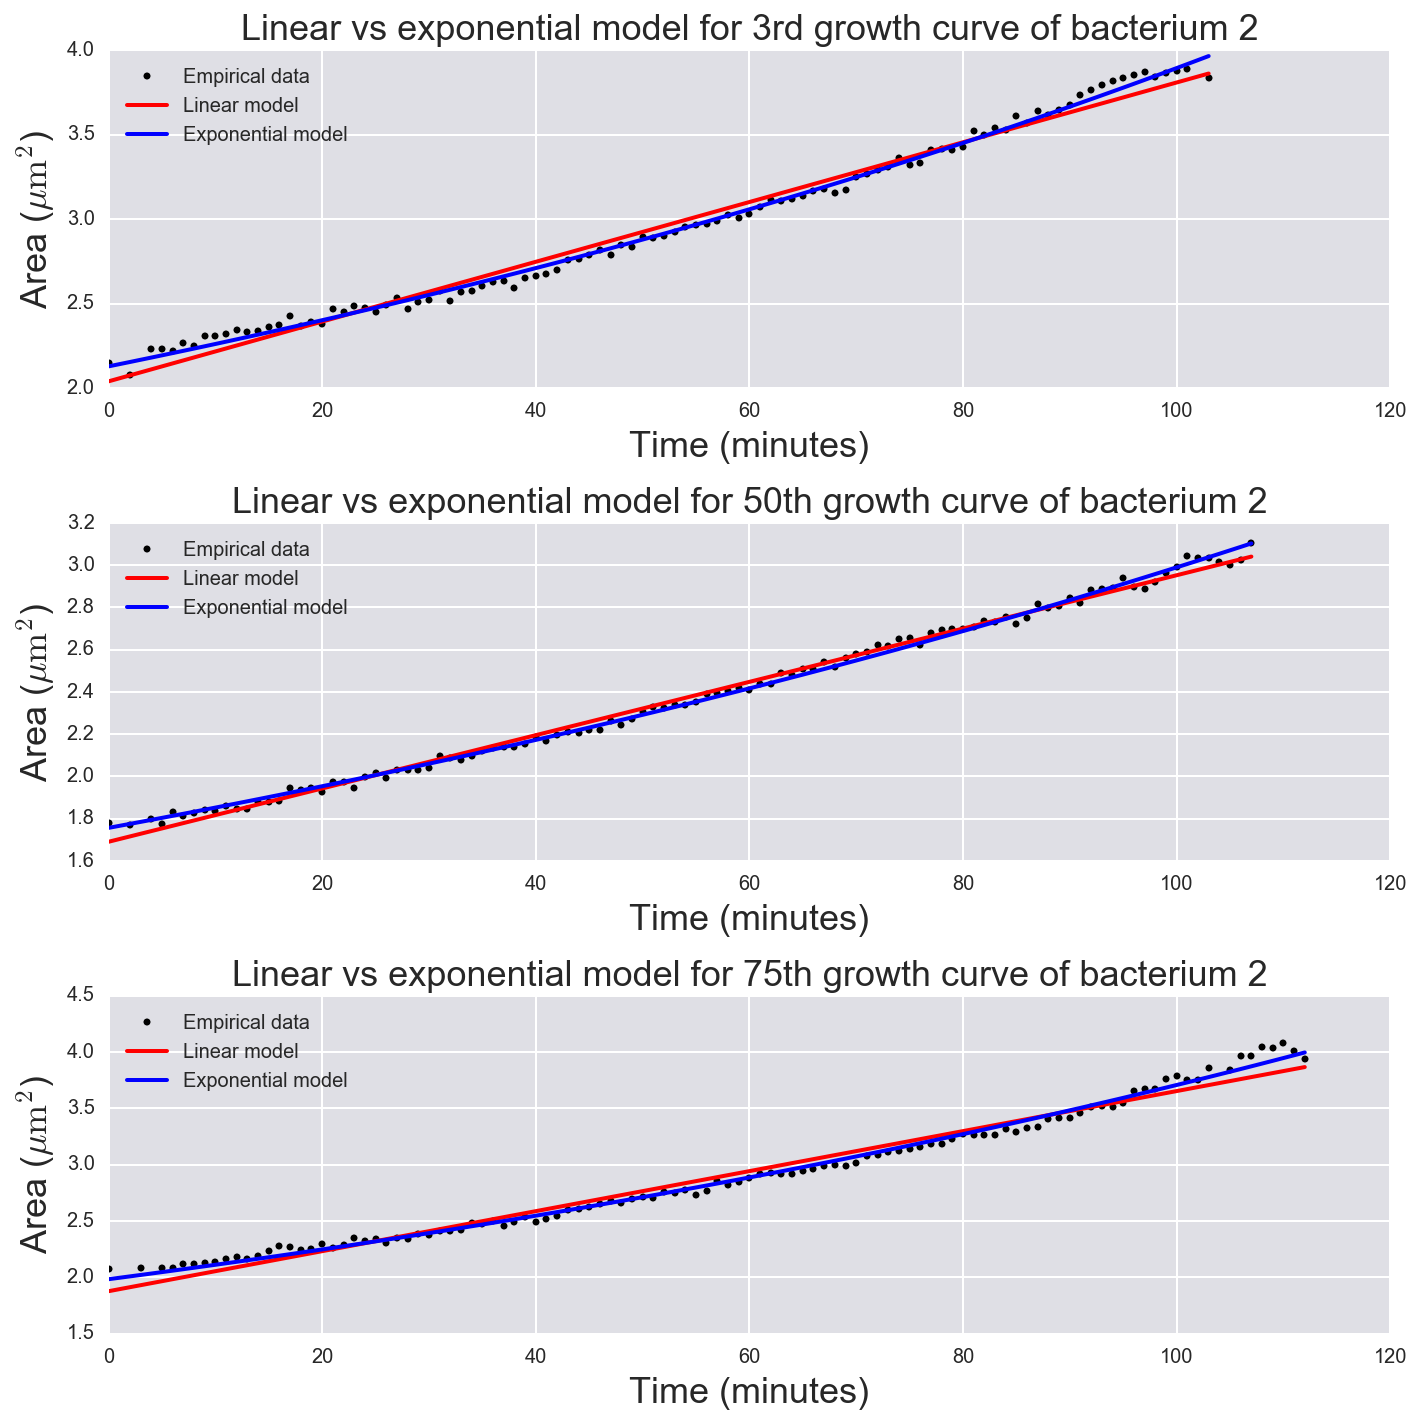

In [38]:
df_list = [df_2_lin, df_2_exp, df_49_lin, df_49_exp, df_74_lin, df_74_exp]
map1_bac2 = []
map2_bac2 = []

for i in range(len(df_list)):
    # Get the index of the most probable parameter set
    df_map = df_list[i][df_list[i].beta_ind == 0]
    max_ind = np.argmax(df_map.lnprob.values)

    # Pull out values.
    map_1, map_2 = df_map.values[max_ind, :2]

    map1_bac2.append(map_1)
    map2_bac2.append(map_2)

f = plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.plot(time_series2[2], area_series2[2], '.', color='k')
plt.plot(time_series2[2],
         lin_theor(np.array([map1_bac2[0], map2_bac2[0]]), time_series2[2]), color='r')
plt.plot(time_series2[2],
         exp_theor(np.array([map1_bac2[1], map2_bac2[1]]), time_series2[2]), color='b')
plt.title('Linear vs exponential model for 3rd growth curve of bacterium 2')
plt.xlabel('Time (minutes)')
plt.ylabel(r'Area ($\mathrm{\mu m^2}$)')
plt.legend(['Empirical data', 'Linear model', 'Exponential model'], loc='topleft')

plt.subplot(3,1,2)
plt.plot(time_series2[49], area_series2[49], '.', color='k')
plt.plot(time_series2[49],
         lin_theor(np.array([map1_bac2[2], map2_bac2[2]]), time_series2[49]), color='r')
plt.plot(time_series2[49],
         exp_theor(np.array([map1_bac2[3], map2_bac2[3]]), time_series2[49]), color='b')
plt.title('Linear vs exponential model for 50th growth curve of bacterium 2')
plt.xlabel('Time (minutes)')
plt.ylabel(r'Area ($\mathrm{\mu m^2}$)')
plt.legend(['Empirical data', 'Linear model', 'Exponential model'], loc='topleft')

plt.subplot(3,1,3)
plt.plot(time_series2[74], area_series2[74], '.', color='k')
plt.plot(time_series2[74],
         lin_theor(np.array([map1_bac2[4], map2_bac2[4]]), time_series2[74]), color='r')
plt.plot(time_series2[74],
         exp_theor(np.array([map1_bac2[5], map2_bac2[5]]), time_series2[74]), color='b')
plt.title('Linear vs exponential model for 75th growth curve of bacterium 2')
plt.xlabel('Time (minutes)')
plt.ylabel(r'Area ($\mathrm{\mu m^2}$)')
plt.legend(['Empirical data', 'Linear model', 'Exponential model'], loc='topleft')
plt.tight_layout()

In [30]:
print('Odds ratio for linear vs exponential, bacterium 2, 3rd growth curve:', np.exp(lnZ_2_lin - lnZ_2_exp))
print('Odds ratio for linear vs exponential, bacterium 2, 50th growth curve:', np.exp(lnZ_49_lin - lnZ_49_exp))
print('Odds ratio for linear vs exponential, bacterium 2, 75th growth curve:', np.exp(lnZ_74_lin - lnZ_74_exp))

Odds ratio for linear vs exponential, bacterium 2, 3rd growth curve: 1.00729548681e-24
Odds ratio for linear vs exponential, bacterium 2, 50th growth curve: 3.49743916966e-11
Odds ratio for linear vs exponential, bacterium 2, 75th growth curve: 2.78499136825e-30


Once again, both from the plots of the theoretical models on top of the raw data, and from the odds ratios, it is pretty clear that the exponential model offers a better description of the growth of *Caulobacter crescentus*. Granted, there is some variation in the magnitude of odds ratio, but even for the 50th growth curve, where the odds ratio is approximately $10^{13}$ times higher than for the 3rd growth curve, the exponential model is still clearly favored. 